In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import PIL
import IPython
from tensorflow.keras import applications, Model

# **DeepDream Network**

In [2]:
def download_image(url):
    name = url.split('/')[-1]
    image_path = tf.keras.utils.get_file(name, origin = url)
    return np.array(PIL.Image.open(image_path))

def deprocess(image):
    '''
    Undo the preprocess function as stated above
    '''
    image = (255.0 * (image + 1.0))/2.0
    return np.clip(image, 0, 255).astype('uint8')

def show(image):
    plt.figure(figsize = (8, 8))
    plt.grid(False)
    plt.axis('off')
    plt.imshow(image)

def calculate_loss(image, model):
    image_batch = tf.expand_dims(image, axis = 0)
    layer_activations = model(image_batch)

    losses = []
    for activation in layer_activations:
        loss = tf.math.reduce_mean(activation)
        losses.append(loss)
    return tf.reduce_sum(losses)

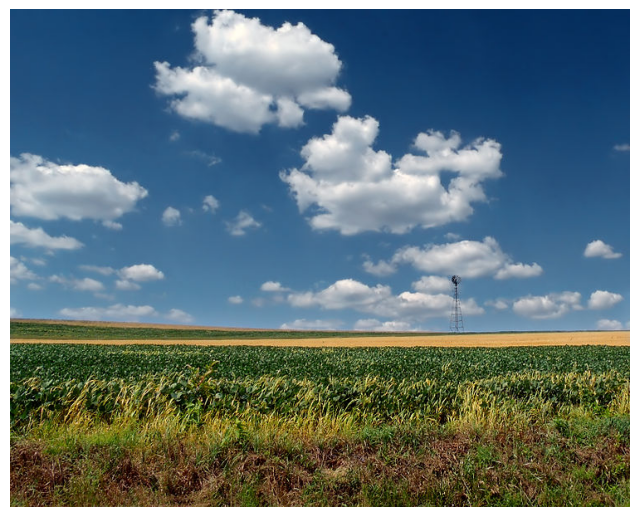

In [3]:
image = applications.inception_v3.preprocess_input(download_image(
    'https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Flickr_-_Nicholas_T_-_Big_Sky_%281%29.jpg/747px-Flickr_-_Nicholas_T_-_Big_Sky_%281%29.jpg'))
show(deprocess(image))

In [4]:
InceptionV3 = applications.InceptionV3(weights = 'imagenet', include_top = False)
layers = [InceptionV3.get_layer(layer).output for layer in ['mixed2', 'mixed3', 'mixed4', 'mixed5']]
# Create the feature extraction model
feature_extraction_model = Model(inputs = InceptionV3.input, outputs = layers)

Step 0 - Loss: 7.11696
Step 50 - Loss: 5.75610
Step 100 - Loss: 6.07739
Step 150 - Loss: 6.30041
Step 200 - Loss: 6.47823
Step 250 - Loss: 6.61904
Step 300 - Loss: 6.74343
Step 350 - Loss: 6.85779


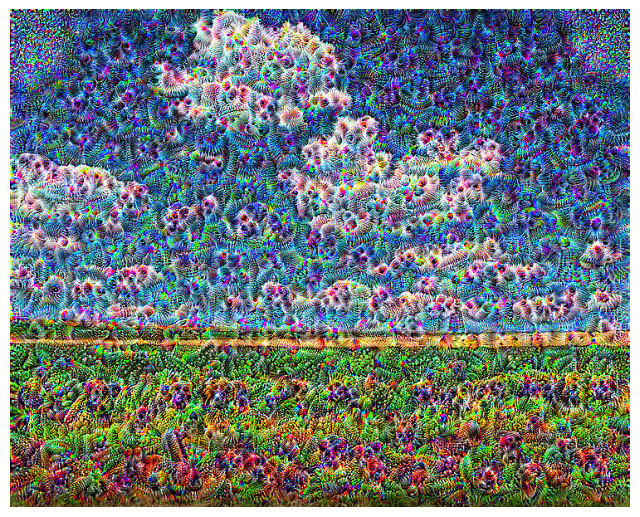

In [6]:
image = tf.convert_to_tensor(image)
for step in range(400):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = calculate_loss(image, feature_extraction_model)

    # Normalize the gradients
    gradients = tape.gradient(loss, image)
    gradients /= tf.math.reduce_std(gradients) + 1e-8
    image += gradients * 0.01
    image = tf.clip_by_value(image, -1, 1)

    if step % 50 == 0:
        print('Step {} - Loss: {:.5f}'.format(step, loss))

show(deprocess(image.numpy()))